<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install d2l -q



     |████████████████████████████████| 82 kB 538 kB/s 
     |████████████████████████████████| 61 kB 6.8 MB/s 
     |████████████████████████████████| 11.2 MB 46.1 MB/s 
     |████████████████████████████████| 9.9 MB 30.9 MB/s 
     |████████████████████████████████| 899 kB 42.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


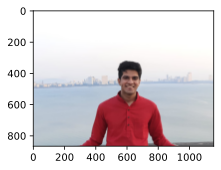

In [2]:
d2l.set_figsize()
img = d2l.Image.open('./me.jpg') 
d2l.plt.imshow(img);

# Augmentation

In [3]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
  Y=[aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

## Flipping and Cropping

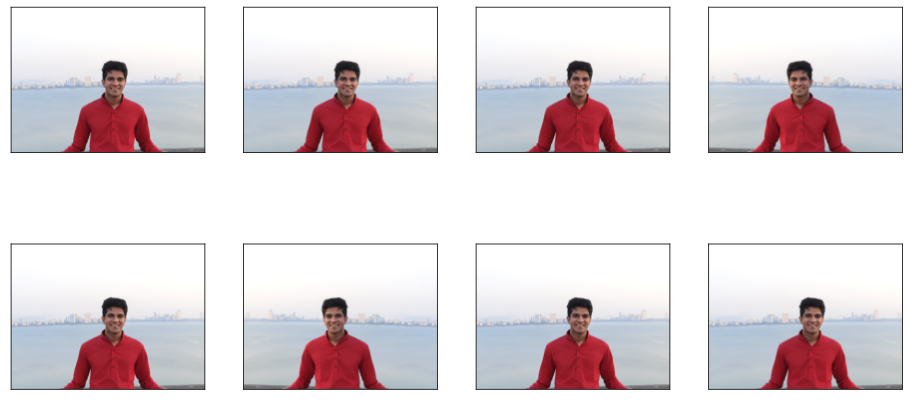

In [7]:
apply(img, torchvision.transforms.RandomHorizontalFlip(),scale=4) #50% chance

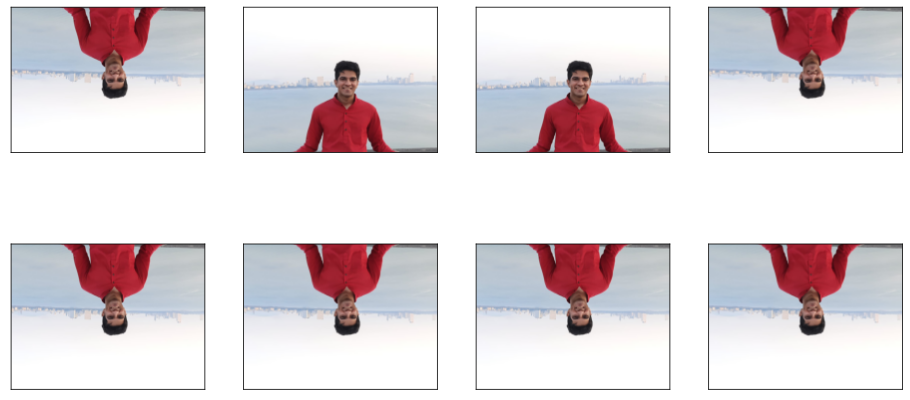

In [8]:
apply(img, torchvision.transforms.RandomVerticalFlip(),scale=4) #50% chance

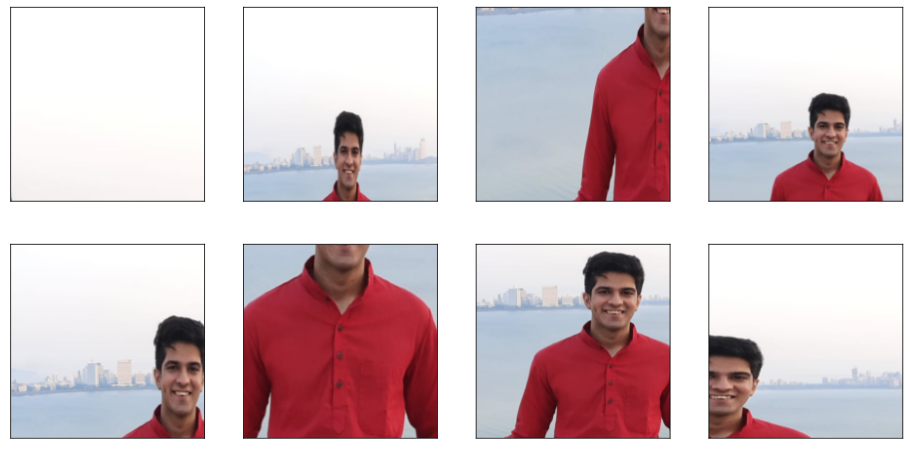

In [9]:
#Resize to 200X200 , crop between 10 to 100% of original area and ratio of width to height is between 0.5 and 2 (inclusive)
shape_aug = torchvision.transforms.RandomResizedCrop( (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug,scale=4)

## Changing colour

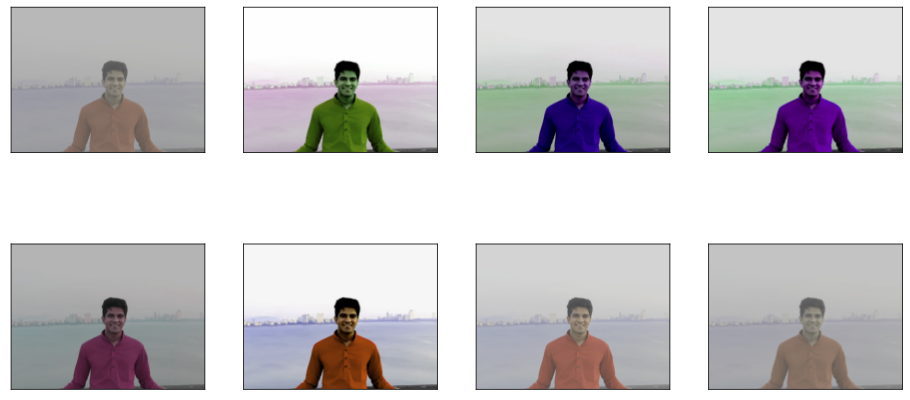

In [13]:
color_aug = torchvision.transforms.ColorJitter(brightness=(0.5,1), contrast=(0.5,1.5), saturation=(0.5,1), hue=(-0.5,0.5))
apply(img, color_aug,scale=4)

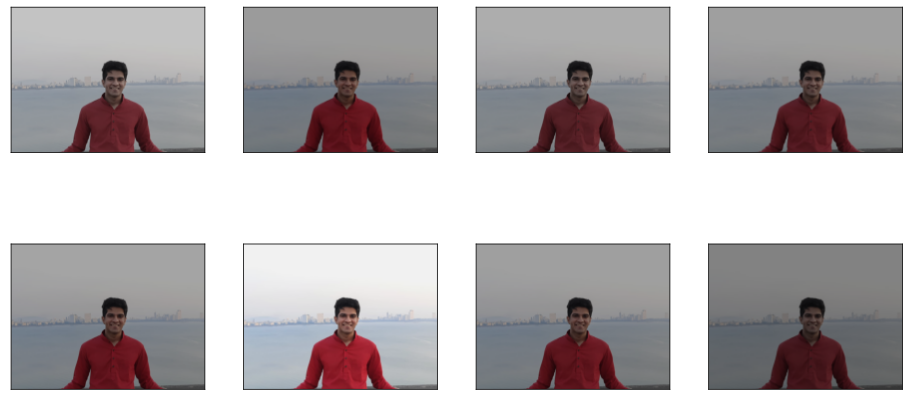

In [14]:
color_aug = torchvision.transforms.ColorJitter(brightness=(0.5,1), contrast=0, saturation=(0.5,1), hue=0)
apply(img, color_aug,scale=4)

## Chaining

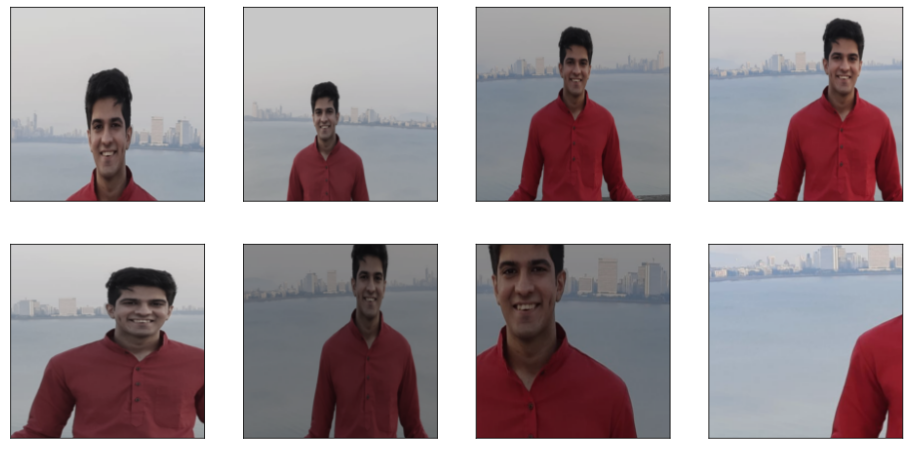

In [15]:
augs = torchvision.transforms.Compose([ torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs,scale=4)

## Training with Augmentation

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


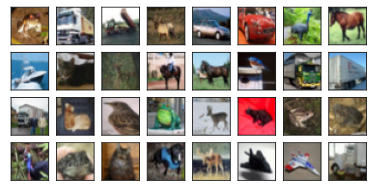

In [16]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations during pre- diction. 

In [24]:
type(all_images[0][0]),all_images[0][1]

(PIL.Image.Image, 6)

In [25]:
train_augs = torchvision.transforms.Compose([ torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([ torchvision.transforms.ToTensor()])

In [26]:
import multiprocessing
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,transform=augs, download=True) 
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=is_train, num_workers=multiprocessing.cpu_count()) 
  return dataloader

In [27]:
def train_batch(net, X, y, loss, trainer, devices):
  X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum() 
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

In [32]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples, no. of predictions
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l,acc=train_batch(net,features,labels,loss,trainer,devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    print(f'epoch {epoch+1}: loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}') 
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

In [29]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight) 
net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001): 
  train_iter = load_cifar10(True, train_augs, batch_size) 
  test_iter = load_cifar10(False, test_augs, batch_size) 
  loss = nn.CrossEntropyLoss(reduction="none")
  trainer = torch.optim.Adam(net.parameters(), lr=lr) 
  train(net, train_iter, test_iter, loss, trainer, 10, devices)

In [30]:
train_with_data_aug(train_augs, test_augs, net)

Files already downloaded and verified
Files already downloaded and verified
loss 1.451, train acc 0.483, test acc 0.471
2810.8 examples/sec on [device(type='cuda', index=0)]
loss 0.853, train acc 0.695, test acc 0.694
1384.8 examples/sec on [device(type='cuda', index=0)]
loss 0.623, train acc 0.782, test acc 0.681
920.2 examples/sec on [device(type='cuda', index=0)]
loss 0.495, train acc 0.828, test acc 0.782
689.4 examples/sec on [device(type='cuda', index=0)]
loss 0.409, train acc 0.857, test acc 0.776
553.4 examples/sec on [device(type='cuda', index=0)]
loss 0.336, train acc 0.884, test acc 0.796
460.2 examples/sec on [device(type='cuda', index=0)]
loss 0.284, train acc 0.900, test acc 0.840
394.1 examples/sec on [device(type='cuda', index=0)]
loss 0.234, train acc 0.920, test acc 0.824
344.6 examples/sec on [device(type='cuda', index=0)]
loss 0.199, train acc 0.931, test acc 0.846
306.8 examples/sec on [device(type='cuda', index=0)]
loss 0.162, train acc 0.946, test acc 0.836
275.6

# Fine-tuning 

1. Pretrain a neural network model, i.e., the source model, on a source dataset (e.g., the ImageNet dataset).

2. Create a new neural network model, i.e., the target model. This copies all model designs and their parameters on the source model except the output layer. We assume that these model parameters contain the knowledge learned from the source dataset and this knowledge will also be applicable to the target dataset. We also assume that the output layer of the source model is closely related to the labels of the source dataset; thus it is not used in the target model.

3. Add an output layer to the target model, whose number of outputs is the number of categories in the target dataset. Then randomly initialize the model parameters of this layer.

4. Train the target model on the target dataset, such as a chair dataset. The output layer will be trained from scratch, while the parameters of all the other layers are fine-tuned based on the parameters of the source model.

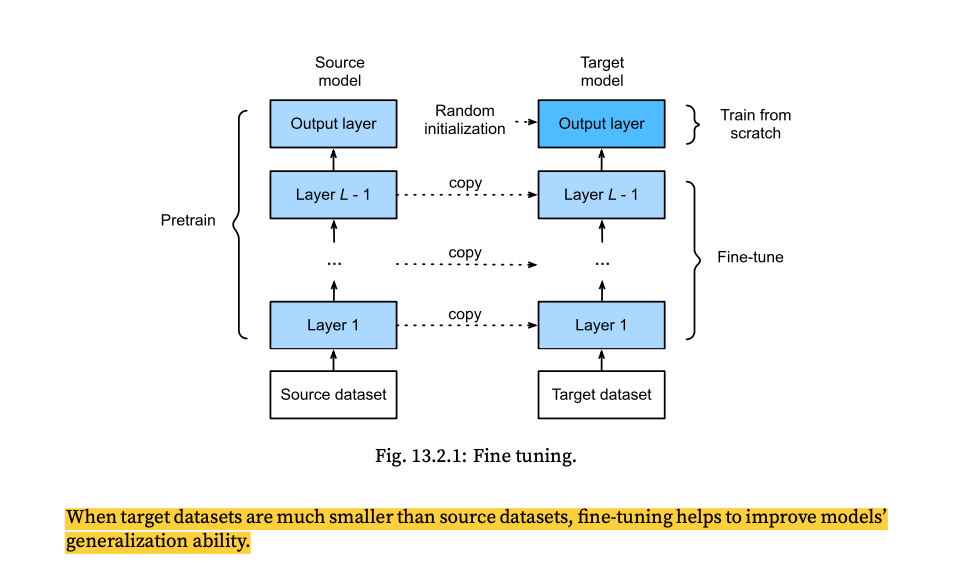

In [31]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [33]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [34]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train')) 
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

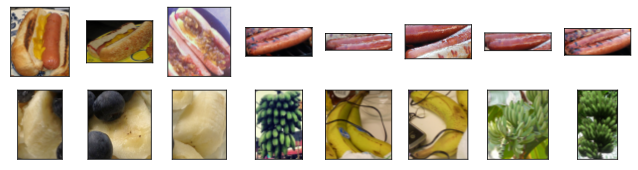

In [35]:
hotdogs = [train_imgs[i][0] for i in range(8)] 
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)] 
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

During training, we first crop a random area of random size and random aspect ratio from the image, and then scale this area to a 224 × 224 input image. During testing, we scale both the height and width of an image to 256 pixels, and then crop a central 224 × 224 area as input. In addition, for the three RGB (red, green, and blue) color channels we standardize their values channel by channel. Concretely, the mean value of a channel is subtracted from each value of that channel and then the result is divided by the standard deviation of that channel.

In [36]:
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([ torchvision.transforms.RandomResizedCrop(224), 
                                             torchvision.transforms.RandomHorizontalFlip(), 
                                             torchvision.transforms.ToTensor(),
                                             normalize])

test_augs = torchvision.transforms.Compose([ torchvision.transforms.Resize(256), 
                                            torchvision.transforms.CenterCrop(224), 
                                            torchvision.transforms.ToTensor(),
                                            normalize])


Since the model parameters in the features are pre-trained on the ImageNet data set and are good enough, generally only a small learning rate is needed to fine-tune these parameters.

The model parameters in the member variable output are initialized randomly, and generally require a larger learning rate to train from scratch. Assuming that the learning rate in the Trainer instance is η, we set the learning rate of the model parameters in the member variable output to be 10η in the iteration.

In [40]:
#To separate out the weights
finetune_net = torchvision.models.resnet18(pretrained=True) 
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) 
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [38]:
# If `fine_tune=True`, the model parameters in the output layer will be updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,fine_tune=True):
  train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),batch_size=batch_size, shuffle=True)
  test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),batch_size=batch_size)

  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction="none") 
  if fine_tune:
    params_body = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
    #We set a global weight decay and learning rate of learning rate and for the head we set a much higher learning rate which 
    #takes priority over the global learning rate

    trainer = torch.optim.SGD([{'params': params_body}, {'params': net.fc.parameters(),'lr': learning_rate * 10}], lr=learning_rate, weight_decay=0.001)

  else:
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,weight_decay=0.001)
  
  train(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

In [41]:
train_fine_tuning(finetune_net, 5e-5 , num_epochs=5)

epoch 1: loss 2.157, train acc 0.694, test acc 0.914
688.7 examples/sec on [device(type='cuda', index=0)]
epoch 2: loss 0.285, train acc 0.912, test acc 0.929
344.4 examples/sec on [device(type='cuda', index=0)]
epoch 3: loss 0.221, train acc 0.922, test acc 0.925
229.7 examples/sec on [device(type='cuda', index=0)]
epoch 4: loss 0.398, train acc 0.881, test acc 0.932
172.1 examples/sec on [device(type='cuda', index=0)]
epoch 5: loss 0.271, train acc 0.908, test acc 0.944
137.7 examples/sec on [device(type='cuda', index=0)]


## Random weights

Shows why fine-tuning is more effective

In [42]:
scratch_net = torchvision.models.resnet18() 
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2) 

#Bigger learning rate since we aren't tuning
train_fine_tuning(scratch_net, 5e-4, fine_tune=False)

epoch 1: loss 2.048, train acc 0.614, test acc 0.781
689.2 examples/sec on [device(type='cuda', index=0)]
epoch 2: loss 0.418, train acc 0.812, test acc 0.719
344.7 examples/sec on [device(type='cuda', index=0)]
epoch 3: loss 0.369, train acc 0.843, test acc 0.812
229.5 examples/sec on [device(type='cuda', index=0)]
epoch 4: loss 0.346, train acc 0.852, test acc 0.859
172.1 examples/sec on [device(type='cuda', index=0)]
epoch 5: loss 0.341, train acc 0.850, test acc 0.834
137.7 examples/sec on [device(type='cuda', index=0)]


## Freeze Body

In [48]:
#To separate out the weights
finetune_net = torchvision.models.resnet18(pretrained=True)
for param in finetune_net.parameters(): 
  param.requires_grad = False 

finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) 
nn.init.xavier_uniform_(finetune_net.fc.weight)

for param in finetune_net.parameters(): 
  print(param.requires_grad)
  


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [49]:
train_fine_tuning(finetune_net, 5e-5 )

epoch 1: loss 4.082, train acc 0.536, test acc 0.881
2185.9 examples/sec on [device(type='cuda', index=0)]
epoch 2: loss 0.432, train acc 0.869, test acc 0.905
1094.1 examples/sec on [device(type='cuda', index=0)]
epoch 3: loss 0.426, train acc 0.867, test acc 0.919
729.7 examples/sec on [device(type='cuda', index=0)]
epoch 4: loss 0.254, train acc 0.904, test acc 0.920
547.4 examples/sec on [device(type='cuda', index=0)]
epoch 5: loss 0.458, train acc 0.849, test acc 0.891
438.0 examples/sec on [device(type='cuda', index=0)]


## Use weights from ImageNet class for given class (Experimental)

Improves fine-tuning results and also starts off at a higher accuracy

In [52]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape

finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) 

#Initialize first
nn.init.xavier_uniform_(finetune_net.fc.weight)

#Now load

finetune_net.fc.weight.data[0,:]=hotdog_w[0]

train_fine_tuning(finetune_net, 5e-5)

epoch 1: loss 1.565, train acc 0.739, test acc 0.932
688.5 examples/sec on [device(type='cuda', index=0)]
epoch 2: loss 0.297, train acc 0.908, test acc 0.901
344.4 examples/sec on [device(type='cuda', index=0)]
epoch 3: loss 0.270, train acc 0.914, test acc 0.938
229.7 examples/sec on [device(type='cuda', index=0)]
epoch 4: loss 0.209, train acc 0.930, test acc 0.932
172.1 examples/sec on [device(type='cuda', index=0)]
epoch 5: loss 0.184, train acc 0.928, test acc 0.936
137.7 examples/sec on [device(type='cuda', index=0)]


In [53]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape

finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) 

#Initialize first
nn.init.xavier_uniform_(finetune_net.fc.weight)

#Now load

finetune_net.fc.weight.data[1,:]=hotdog_w[0]

train_fine_tuning(finetune_net, 5e-5)


epoch 1: loss 2.535, train acc 0.654, test acc 0.891
689.1 examples/sec on [device(type='cuda', index=0)]
epoch 2: loss 0.376, train acc 0.892, test acc 0.915
344.6 examples/sec on [device(type='cuda', index=0)]
epoch 3: loss 0.296, train acc 0.898, test acc 0.901
229.4 examples/sec on [device(type='cuda', index=0)]
epoch 4: loss 0.221, train acc 0.918, test acc 0.909
172.1 examples/sec on [device(type='cuda', index=0)]
epoch 5: loss 0.218, train acc 0.920, test acc 0.910
137.7 examples/sec on [device(type='cuda', index=0)]
